# Model Training

In [1]:
from meli import full_pipe

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Giovanni\.conda\envs\meli\lib\site-packages\ipykernel\parentpoller.py:109: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [2]:
def build_dataset():
    data = [json.loads(x) for x in open("../ml_evaluation/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    # NOTE: adding these lines to avoid data leakage
    for x in X_train:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = build_dataset()

In [4]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    shuffle=True,
    test_size=10_000
)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((80000, 47), (10000, 47), (10000, 47))

In [7]:
pipe = Pipeline(
    [
        ('transformations', full_pipe),
        ('clf', GradientBoostingClassifier())
    ]
)

In [27]:
params = [
    {
        'clf': [CatBoostClassifier()],
        'clf__n_estimators': [100, 500, 1000],
        'clf__verbose': [False],
        'clf__depth': [None, 5, 10]
    }
]

In [28]:
kf = KFold(n_splits=3, shuffle=True)

In [29]:
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=kf, verbose=10, n_jobs=-1)

In [30]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('transformations',
                                        Pipeline(steps=[('pipeline',
                                                         Pipeline(steps=[('featuregeneration',
                                                                          FeatureGeneration())])),
                                                        ('featureunion',
                                                         FeatureUnion(transformer_list=[('pipeline-1',
                                                                                         Pipeline(steps=[('columnselector',
                                                                                                          ColumnSelector(columns=['listing_type_id',
                                                                                                                                  'tags',
                       

In [33]:
y_hat = grid.predict(X_train)

print(classification_report(y_train, y_hat))
print()
y_hat = grid.predict(X_val)
print(classification_report(y_val, y_hat))

              precision    recall  f1-score   support

         new       0.99      0.99      0.99     43028
        used       0.99      0.99      0.99     36972

    accuracy                           0.99     80000
   macro avg       0.99      0.99      0.99     80000
weighted avg       0.99      0.99      0.99     80000


              precision    recall  f1-score   support

         new       0.87      0.87      0.87      5324
        used       0.86      0.85      0.85      4676

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [13]:
data = full_pipe.fit_transform(X_train)

In [20]:
data_val = full_pipe.transform(X_val)

In [22]:
data_test = full_pipe.transform(X_test)

In [21]:
cat = CatBoostClassifier(verbose=1)

cat.fit(X=data, y=y_train, eval_set=(data_val, y_val))

Learning rate set to 0.093535
0:	learn: 0.6461583	test: 0.6463786	best: 0.6463786 (0)	total: 191ms	remaining: 3m 10s
1:	learn: 0.6061878	test: 0.6068216	best: 0.6068216 (1)	total: 218ms	remaining: 1m 48s
2:	learn: 0.5740579	test: 0.5748991	best: 0.5748991 (2)	total: 245ms	remaining: 1m 21s
3:	learn: 0.5494499	test: 0.5505127	best: 0.5505127 (3)	total: 270ms	remaining: 1m 7s
4:	learn: 0.5305075	test: 0.5314751	best: 0.5314751 (4)	total: 295ms	remaining: 58.7s
5:	learn: 0.5145720	test: 0.5157343	best: 0.5157343 (5)	total: 320ms	remaining: 53.1s
6:	learn: 0.5003177	test: 0.5015695	best: 0.5015695 (6)	total: 346ms	remaining: 49.1s
7:	learn: 0.4894247	test: 0.4906547	best: 0.4906547 (7)	total: 372ms	remaining: 46.1s
8:	learn: 0.4786294	test: 0.4799020	best: 0.4799020 (8)	total: 400ms	remaining: 44s
9:	learn: 0.4713529	test: 0.4728792	best: 0.4728792 (9)	total: 426ms	remaining: 42.2s
10:	learn: 0.4647226	test: 0.4670628	best: 0.4670628 (10)	total: 454ms	remaining: 40.8s
11:	learn: 0.4592732	

In [25]:
y_hat = cat.predict(data)
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

         new       0.92      0.92      0.92     43028
        used       0.90      0.90      0.90     36972

    accuracy                           0.91     80000
   macro avg       0.91      0.91      0.91     80000
weighted avg       0.91      0.91      0.91     80000



In [23]:
y_hat = cat.predict(data_val)

In [24]:
print(classification_report(y_val, y_hat))

              precision    recall  f1-score   support

         new       0.87      0.87      0.87      5324
        used       0.85      0.85      0.85      4676

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [26]:
y_hat = cat.predict(data_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         new       0.87      0.87      0.87      5406
        used       0.85      0.85      0.85      4594

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [142]:
import os
def make_report(model, X, y, title='Train Metrics', filename='report.md'):
    y_hat = model.predict(X)
    report = classification_report(y, y_hat, output_dict=True)
    report['accuracy'] = {
        'precision':'',
        'recall':'',
        'f1-score': report.get('accuracy', ''),
        'support': report.get('macro avg', {}).get('support')
    }
    report = pd.DataFrame(report).T
    
    plt.title(f"\nConfusion Matrix\n")
    fig = sns.heatmap(
        confusion_matrix(y, y_hat),
        annot=True,
        fmt='.2f'
    )
    base_path = os.path.splitext(filename)[0]
    cm_image_path =f'{base_path}_cf.png' 
    plt.savefig(cm_image_path)
    fig.clear()
    del fig
    
    try:
        features = pd.Series(model.feature_importances_,
                             index=model.feature_names_)
        features = features.sort_values(ascending=False)
        features = features.head(20)
    except Exception as e:
        features = None
    
    full_report = f"# Model report\n"
    full_report += f"## {title}\n"
    full_report += f"\n### Algorithm information:\n\n{model.__str__()}\n"
    full_report += f"\n### Classification_report:\n\n"
    full_report += report.to_markdown()
    full_report += "\n\n### Confusion Matrix"
    full_report += f"\n\n![ ]({cm_image_path})"
    
    if isinstance(features, pd.Series):
        plt.title(f'\nFeature Importances')
        fig = sns.barplot(x=features.values, y=features.index)
        fi_image_path = f'{base_path}_fi.png'
        plt.savefig(fi_image_path)
        full_report += "\n\n### Feature Importances"
        full_report += f"\n\n![ ]({fi_image_path})"
        
    with open(filename, 'w') as f:
        f.write(full_report)
    

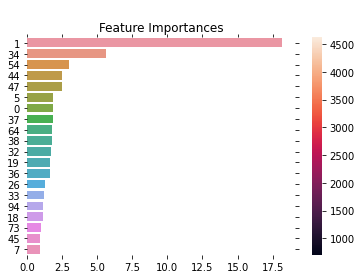

In [143]:
make_report(cat, data_val, y_val)